In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

from scipy.stats import norm
%load_ext autoreload
%autoreload 2

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from dpk.koopman_probabilistic import KoopmanProb
from dpk.model_objs import NormalNLL

[ Using Seed :  633  ]


In [3]:

def normal_lik(data, mean_hat, std_hat):
    """geoemtric mean of the likelihood of data given a normal distribution"""
    assert(len(data) == len(mean_hat) and len(mean_hat) == len(std_hat))
    log_lik = np.mean(np.log(norm.pdf(data, loc=mean_hat, scale=std_hat)))
    return np.exp(log_lik)

def nmb(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return np.mean(pred - data) / np.mean(data)

def nrmse(data, pred):
    """Normalized root mean square error"""
    assert(len(data) == len(pred))
    sorted_data = sorted(data)
    o05 = sorted_data[int(len(data) * 0.05)]
    o95 = sorted_data[int(len(data) * 0.95)]
    return float(np.sqrt(np.mean((data - pred)**2)) / (o95 - o05))

from scipy.stats import pearsonr
def correlation(data, pred):
    """Pearson correlation"""
    assert(len(data) == len(pred))
    return pearsonr(data, pred)[0]

In [4]:
import json
with open("./HighNO2/HighNO2.json") as f:
    HighNO2 = json.loads(f.read())
HighNO2

{'EEA_FR_FR04012': {'pre-covid': {}, 'covid': {}},
 'EEA_FR_FR04058': {'pre-covid': {'gm_lik': 0.2706810554849785,
   'nmb': 0.15407675905632956,
   'nrmse': 0.3398473705006741,
   'correlation': 0.31728574068470433},
  'covid': {'gm_lik': 0.27063532078536406,
   'nmb': -0.17807765131787007,
   'nrmse': 0.27651434685175696,
   'correlation': 0.5932220835693274}},
 'Station0005229': {'pre-covid': {'gm_lik': 0.31411846809558236,
   'nmb': 0.18666239919135852,
   'nrmse': 0.32682324590451733,
   'correlation': 0.4315345475618543},
  'covid': {'gm_lik': 0.3115533102947196,
   'nmb': -0.24253467769972967,
   'nrmse': 0.249448133056651,
   'correlation': 0.7258880860810151}},
 'EEA_FR_FR04131': {'pre-covid': {'gm_lik': 0.3195263481479291,
   'nmb': 0.2243785364753817,
   'nrmse': 0.32874709663076024,
   'correlation': 0.39429602926966406},
  'covid': {'gm_lik': 0.2004859495556537,
   'nmb': -0.36713885750463043,
   'nrmse': 0.31820417873578516,
   'correlation': 0.6531546141665785}}}

In [133]:
station_name = "EEA_FR_FR04131"
station_fname = f"model_analysis_{station_name}.csv"

In [134]:
station_path = "./HighNO2/"
# for fname in os.listdir(station_path):
#     if fname.startswith("obs_") and fname[len("obs_"):-len(".csv")] not in HighNO2.keys():
#         station_name = fname[len("obs_"):-len(".csv")]
#         break
# station_name

In [135]:
HighNO2[station_name] = {"pre-covid": dict(), "covid": dict()}

In [136]:
start_date = np.datetime64("2018-01-16")
if station_fname.startswith("obs"):
    obsfile = os.path.join(station_path, station_fname)
    obs = pd.read_csv(obsfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    obs = obs[obs.ISO8601 >= start_date]
    obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
    t_min = obs.t.min()
    obs.t -= t_min
    obs_no2 = obs.loc[obs.obstype=='no2']
 
    obs_no2

In [137]:
start_date = np.datetime64("2018-01-16")
if station_fname.startswith("model_analysis"):
    modfile = os.path.join(station_path, station_fname)
    mod = pd.read_csv(modfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    mod.ISO8601 -= dt.timedelta(minutes=30)  # the timestamps in mod were misaligned
    mod = mod[mod.ISO8601 >= start_date]
    mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
    t_min = mod.t.min()
    mod.t -= t_min

    mod

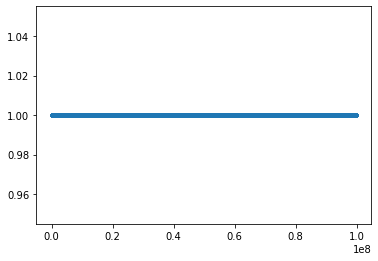

In [138]:
plt.plot(obs.t, np.ones(len(obs.t)), ".")

x (34704, 1)
t (34704,)
[]
x (34704, 1)
t (34704,)


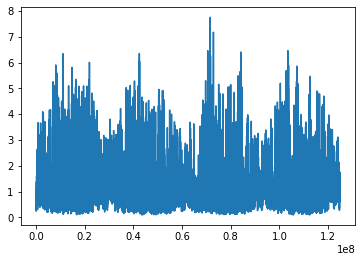

In [139]:
chemical = "NO2"
if station_fname.startswith("obs"):
    x = np.expand_dims(obs_no2.conc_obs.values, -1)
    t = obs_no2.t.values
else:
    x = np.expand_dims(mod.no2.values, -1)
    t = mod.t.values
print("x", x.shape)
print("t", t.shape)
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2
if x.min() <= 0:
    print("nonpositive observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20
x_original = x
scale = np.std(x, axis=0)
x = x / np.tile(scale, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)
plt.figure()
plt.plot(t, x)

x (20424, 1)
x_train (17544, 1)


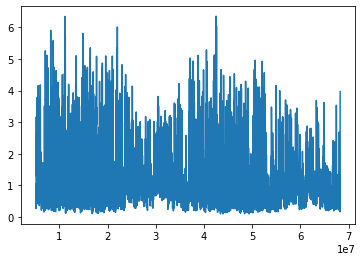

In [140]:
train_start_date = np.datetime64("2018-03-16")
train_end_date = np.datetime64("2020-03-16")
covid_end_date = np.datetime64("2020-05-16")
if station_fname.startswith("obs"):
    train_start = np.argwhere(obs_no2.ISO8601.values >= train_start_date)[0, 0]
    train_end = np.argwhere(obs_no2.ISO8601.values <= train_end_date)[-1, 0]
    covid_end = np.argwhere(obs_no2.ISO8601.values <= covid_end_date)[-1, 0]
else:
    train_start = np.argwhere(mod.ISO8601.values >= train_start_date)[0, 0]
    train_end = np.argwhere(mod.ISO8601.values <= train_end_date)[-1, 0]
    covid_end = np.argwhere(mod.ISO8601.values <= covid_end_date)[-1, 0]
data_name = chemical + station_name

x = x[:covid_end]
t = t[:covid_end]

delay = 0

x_train = x[train_start:train_end]
t_train = t[train_start:train_end]

now = ("_".join(str(datetime.now()).split())).replace(":", ".")
print("x", x.shape)
print("x_train", x_train.shape)
plt.figure()
plt.plot(t_train, x_train)
plt.show()

In [141]:
train_start, train_end, covid_end

(1416, 18960, 20424)

In [142]:
periods = 60 * 60 * np.array([24, 24 * 7, 24 * 365.24], dtype=np.float64)  # seconds
l1width = 256
l2width = 1024
wd = 1e-3
lrt = 1e-4
batch_size = 32
model = NormalNLL(x_dim=1, num_freqs=3, n=l1width, n2=l2width, num_covariates=1)

total_iters = 100
param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
# param_str = f"NormalNLL_default_{l1width}_{l2width}"
model.load_state_dict(torch.load(f"forecasts/model_{param_str}.pt"))

koop = KoopmanProb(model, batch_size=batch_size, device="cpu")
koop.init_periods(periods)
total_iters = 0

In [143]:
iters = 1
total_iters += iters
koop.fit(x_train, t_train, covariates=t_train.reshape(len(t_train), 1), iterations=iters, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)

Iteration  0
tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000])
Setting periods to tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000], grad_fn=<MulBackward0>)
Loss:  0.10100182
Final loss: 0.10100182


[0.10100182]

In [144]:
params = koop.predict(t, covariates=t.reshape(len(t), 1))
mu_hat, sigma_hat = params
mean_hat = model.mean(params)
std_hat = model.std(params)

In [145]:
param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")

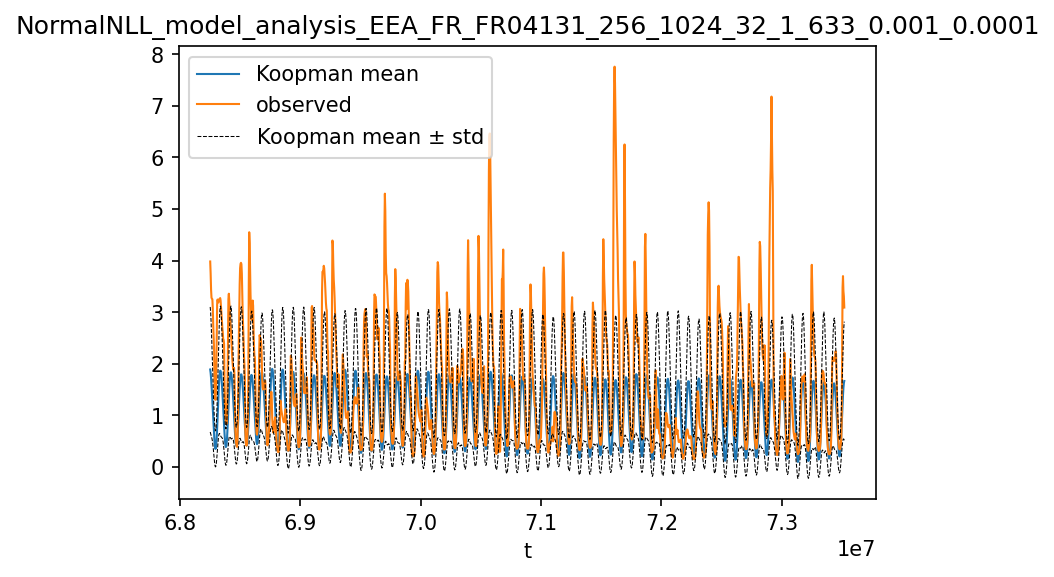

In [146]:
mean_hat = model.mean(params)
std_hat = model.std(params)
plt.figure(dpi=150)
plt.plot(t[train_end:], mean_hat[train_end:, 0], label="Koopman mean", linewidth=1)
plt.plot(t[train_end:], x[train_end:, 0], label="observed", linewidth=1)
plt.plot(t[train_end:], mean_hat[train_end:, 0] + std_hat[train_end:, 0], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(t[train_end:], mean_hat[train_end:, 0] - std_hat[train_end:, 0], "--", color="black", linewidth=0.5)

plt.title(f"{param_str}")
plt.xlabel("t")
# plt.xlim([7e7, 7.1e7])
plt.legend()
plt.show()

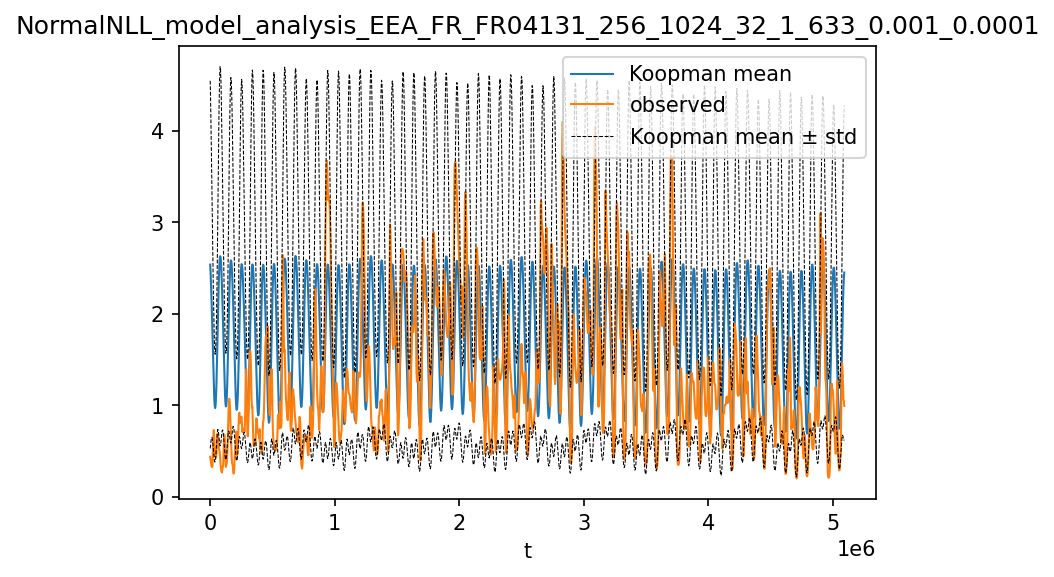

In [147]:
mean_hat = model.mean(params)
std_hat = model.std(params)
plt.figure(dpi=150)
plt.plot(t[:train_start], mean_hat[:train_start, 0], label="Koopman mean", linewidth=1)
plt.plot(t[:train_start], x[:train_start, 0], label="observed", linewidth=1)
plt.plot(t[:train_start], mean_hat[:train_start, 0] + std_hat[:train_start, 0], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(t[:train_start], mean_hat[:train_start, 0] - std_hat[:train_start, 0], "--", color="black", linewidth=0.5)
# plt.xlim([6e6,1.3e7])
plt.title(f"{param_str}")
plt.xlabel("t")
plt.legend()
plt.show()

In [148]:
len(x), len(mean_hat), len(std_hat)

(20424, 20424, 20424)

In [149]:
HighNO2[station_name]["pre-covid"]["gm_lik"] = normal_lik(x[0:train_start], mean_hat[0:train_start], std_hat[0:train_start])
HighNO2[station_name]["pre-covid"]["nmb"] = nmb(x[0:train_start], mean_hat[0:train_start])
HighNO2[station_name]["pre-covid"]["nrmse"] = nrmse(x[0:train_start], mean_hat[0:train_start])
HighNO2[station_name]["pre-covid"]["correlation"] = correlation(x[0:train_start, 0], mean_hat[0:train_start, 0])

HighNO2[station_name]["covid"]["gm_lik"] = normal_lik(x[train_end:], mean_hat[train_end:], std_hat[train_end:])
HighNO2[station_name]["covid"]["nmb"] = nmb(x[train_end:], mean_hat[train_end:])
HighNO2[station_name]["covid"]["nrmse"] = nrmse(x[train_end:], mean_hat[train_end:])
HighNO2[station_name]["covid"]["correlation"] = correlation(x[train_end:, 0], mean_hat[train_end:, 0])
HighNO2[station_name]

{'pre-covid': {'gm_lik': 0.29435480850992063,
  'nmb': 0.2817898831409897,
  'nrmse': 0.3568838399458881,
  'correlation': 0.35549255976424265},
 'covid': {'gm_lik': 0.22562521738592267,
  'nmb': -0.350485042500101,
  'nrmse': 0.3188222897572965,
  'correlation': 0.629988421525319}}

In [150]:
with open("./HighNO2/HighNO2.json", "w") as f:
    f.write(json.dumps(HighNO2))

In [151]:
print(normal_lik(x[train_start:train_end], mean_hat[train_start:train_end], std_hat[train_start:train_end]))
print(nmb(x[train_start:train_end], mean_hat[train_start:train_end]))
print(nrmse(x[train_start:train_end], mean_hat[train_start:train_end]))
print(correlation(x[train_start:train_end, 0], mean_hat[train_start:train_end, 0]))

0.3617387406905118
0.02316851939420615
0.2655044801483144
0.5721505437325655


ideas:
- make calibration diagram
    - quantify this with the NMAE from uniform? (also incorporate sample size, independence)
- threshhold on some metric (like a probability of some statistic being as extreme or more extreme than some value)

In [152]:
# find the sampling distribution of consecutive k-averages (k_average = average z-score of k consecutive observations)
k = 24 * 7
z_scores = (x - mean_hat) / std_hat
k_averages = []
k_mses = []
k_samples = np.zeros((covid_end - k + 1, k))

for i in range(0, covid_end - k + 1):
    sample = z_scores[i:i+k]
    k_averages.append(np.mean(sample))
    k_mses.append(np.mean(sample**2))
    k_samples[i, :] = sample.flatten()

train_z_scores = z_scores[train_start:train_end - k + 1]

In [153]:
alpha = 0.001
train_k_averages = k_averages[train_start:train_end - k + 1]
covid_k_averages = k_averages[train_end:]
control_k_averages = k_averages[:train_start - k + 1]
critical_z_bar = sorted(train_k_averages)[int(len(train_k_averages) * alpha)]

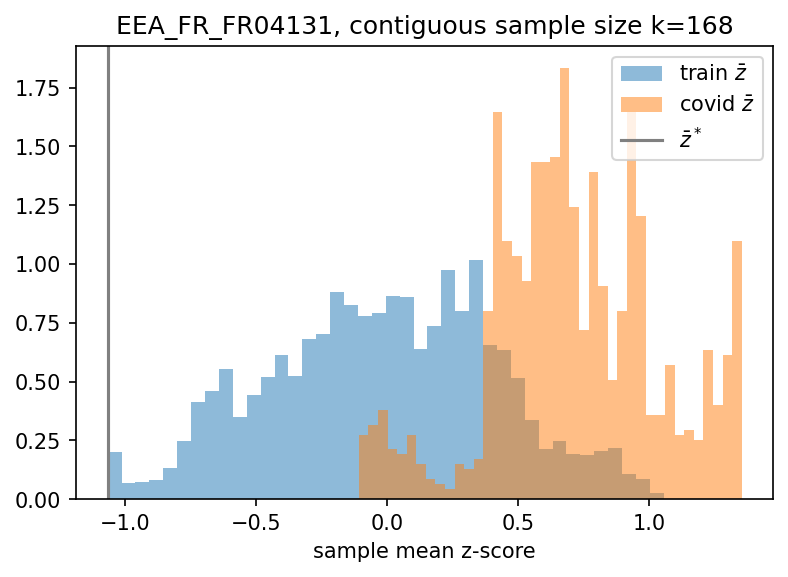

In [154]:
plt.figure(dpi=150)
plt.hist(train_k_averages, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar z$")
# plt.hist(control_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="hindcast $\\bar z$")
plt.hist(covid_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar z$")
plt.axvline(critical_z_bar, color="gray", label="$\\bar z^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean z-score")
l = np.linspace(min(train_k_averages), max(train_k_averages))
# if consecutive z-scores were iid, we would expect this distribution to have std = 1/sqrt(k)
# plt.plot(l, norm.pdf(l, loc=0, scale=1/np.sqrt(k)), label="sample mean of iid z-scores")
plt.legend()

In [155]:
alpha = 0.001
train_k_mses = k_mses[train_start:train_end - k + 1]
covid_k_mses = k_mses[train_end:]
control_k_mses = k_mses[:train_start - k + 1]
critical_mse_z = sorted(control_k_mses)[-int(len(control_k_mses) * alpha)]

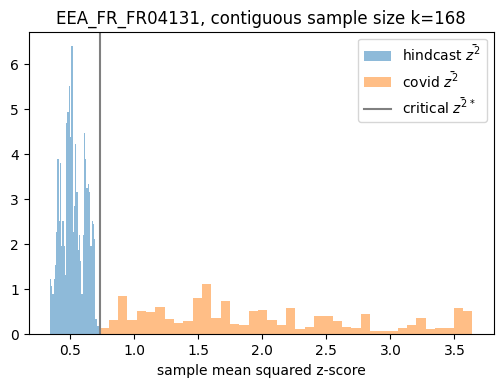

In [156]:
plt.figure(dpi=100)
# plt.hist(train_k_mses, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar{z^2}$")
plt.hist(control_k_mses, bins=40, density=True, color="tab:blue", alpha=0.5, label="hindcast $\\bar{z^2}$")
plt.hist(covid_k_mses, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar{z^2}$")
plt.axvline(critical_mse_z, color="gray", label="critical $\\bar{z^2}^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean squared z-score")
plt.legend()

In [157]:
train_distr = train_z_scores
t_idx = 11000
test_distr = k_samples[t_idx, :]
P = lambda distr, lo, hi: np.sum((lo <= distr) & (distr < hi)) / len(distr)
n_bins = 1000
bins = np.linspace(min(train_distr.min(), test_distr.min()), max(train_distr.max(), test_distr.max()) + 1e-100, n_bins + 1, endpoint=True)
KL = np.sum([P(train_distr, bins[i], bins[i + 1]) * (np.log(P(train_distr, bins[i], bins[i + 1]) + 1e-100) - np.log(P(test_distr, bins[i], bins[i + 1]) + 1e-100)) for i in range(n_bins)])  # this is asymmetric, and compares test to control

In [158]:
KL

157.25533184564034

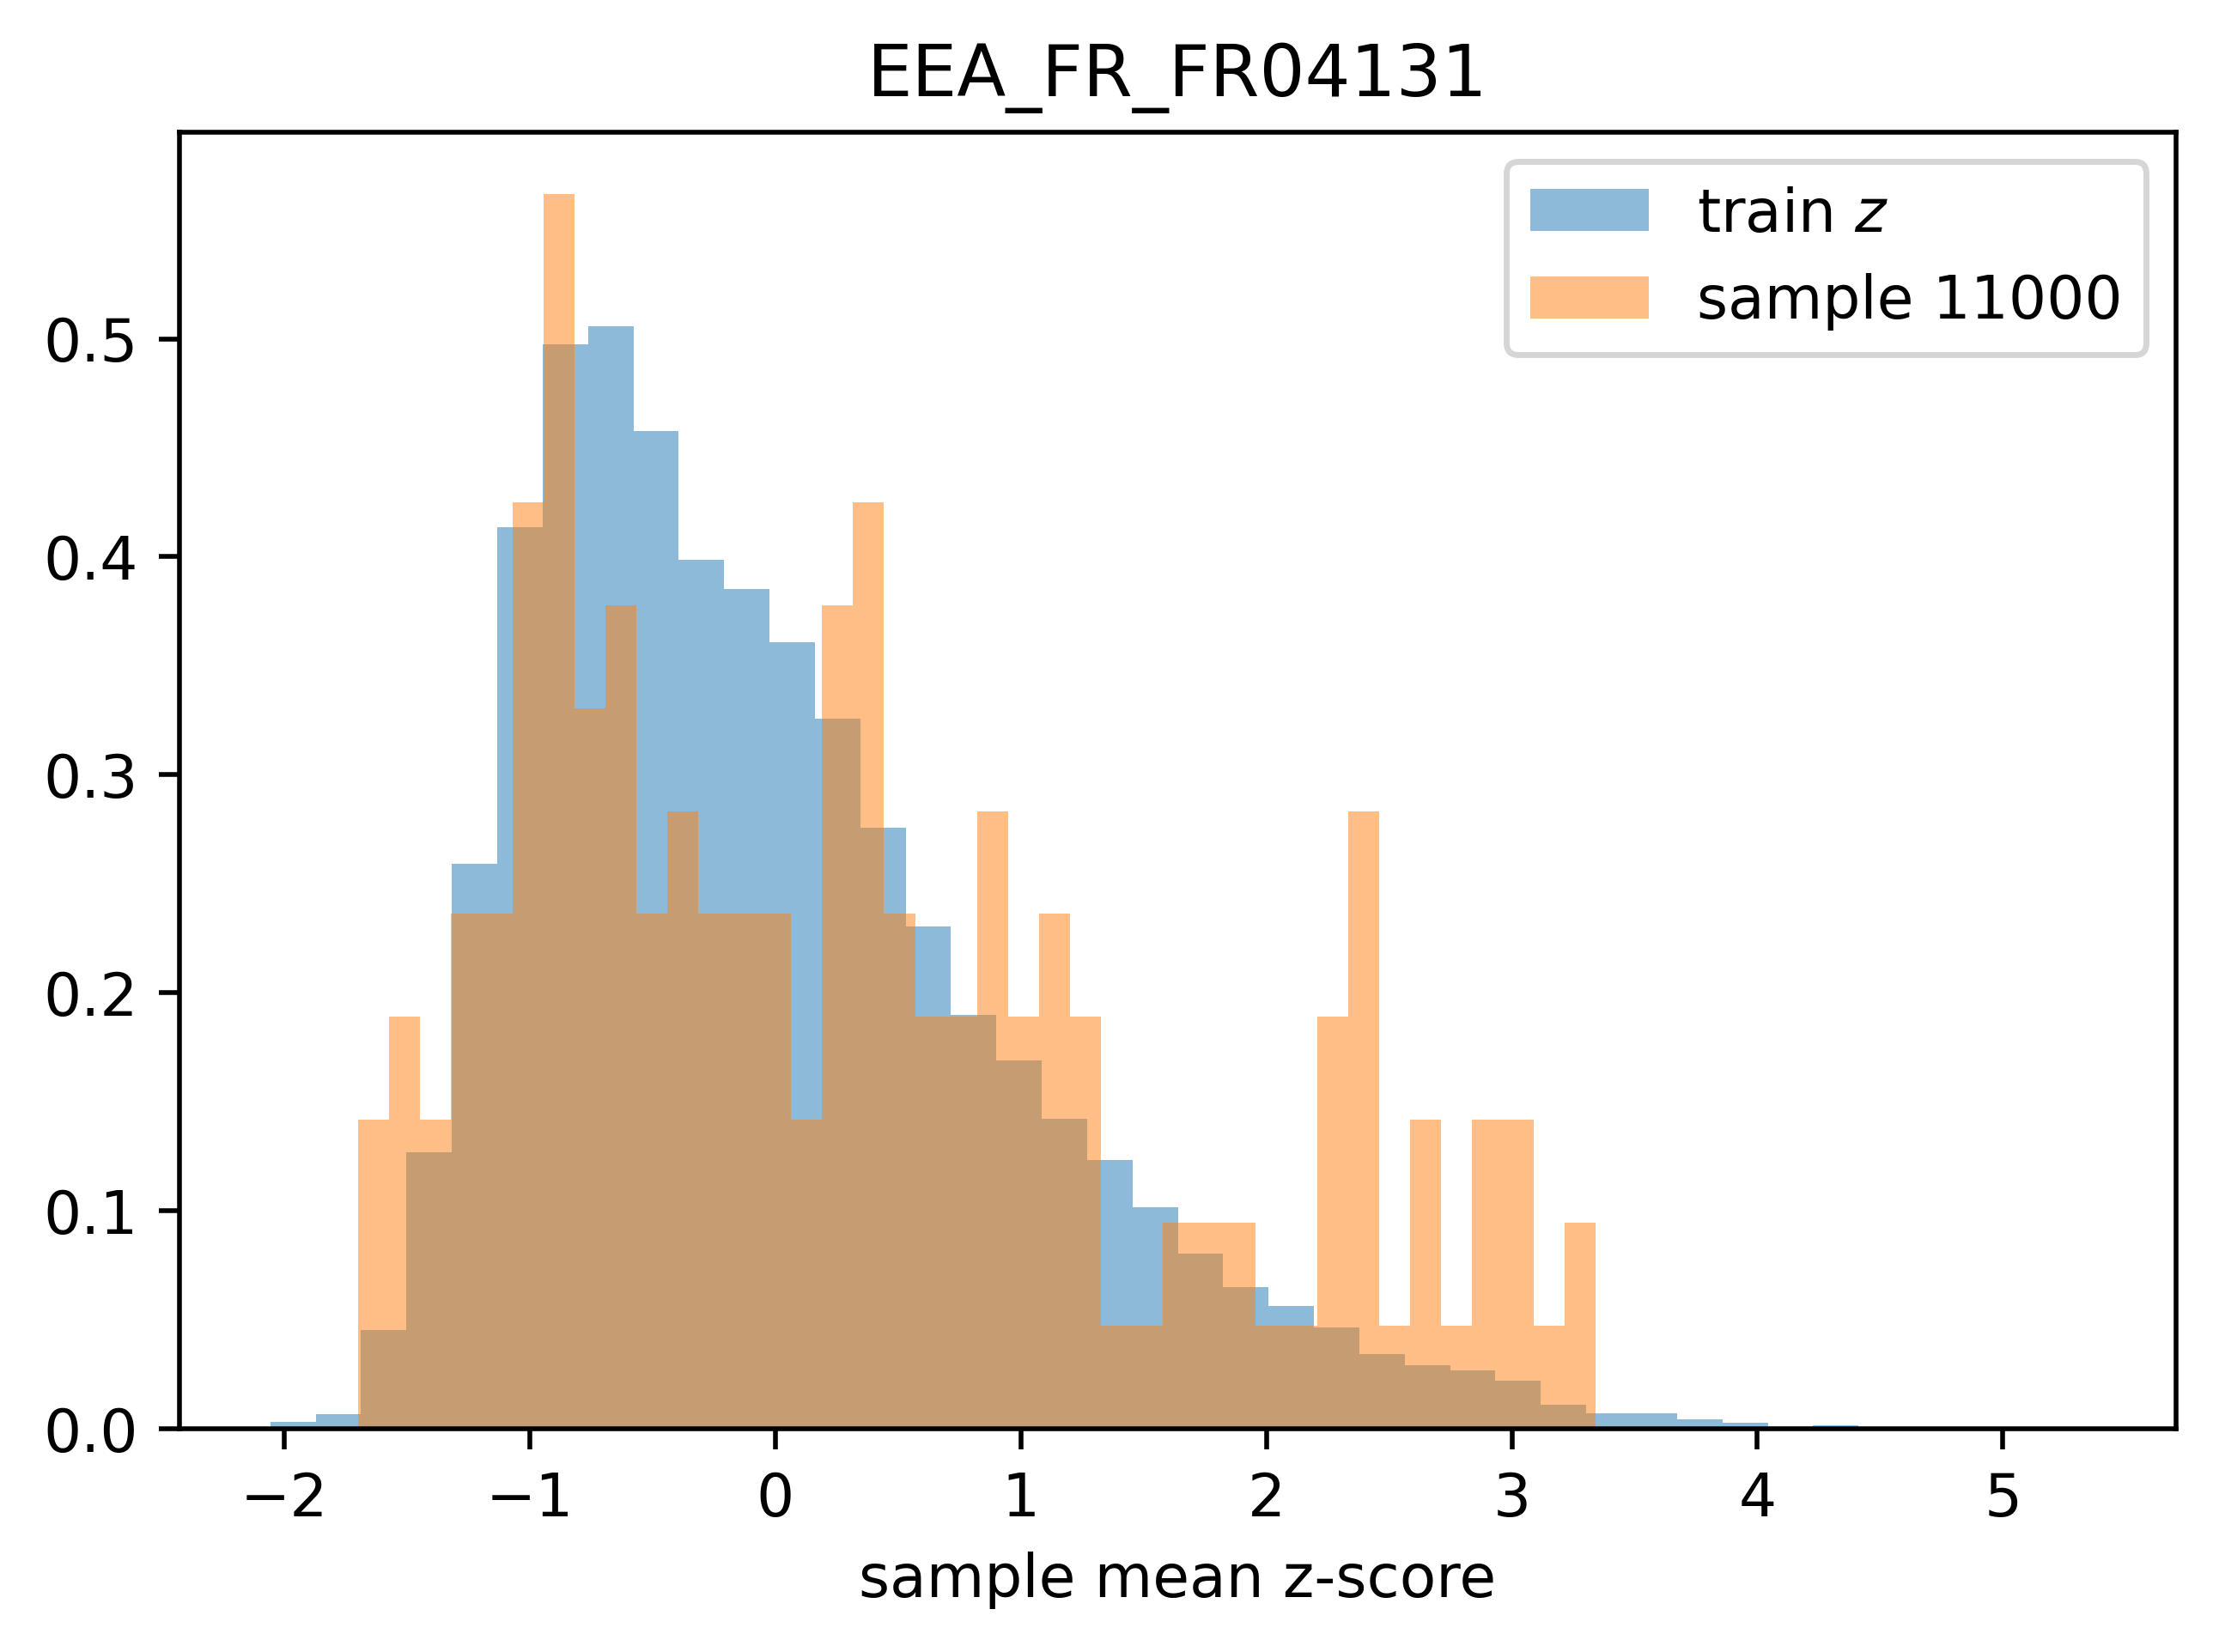

In [159]:
plt.figure(dpi=500)
plt.hist(train_distr, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $z$")
plt.hist(test_distr, bins=40, density=True, color="tab:orange", alpha=0.5, label=f"sample {t_idx}")
plt.title(f"{station_name}")
plt.xlabel("sample mean z-score")
plt.legend()

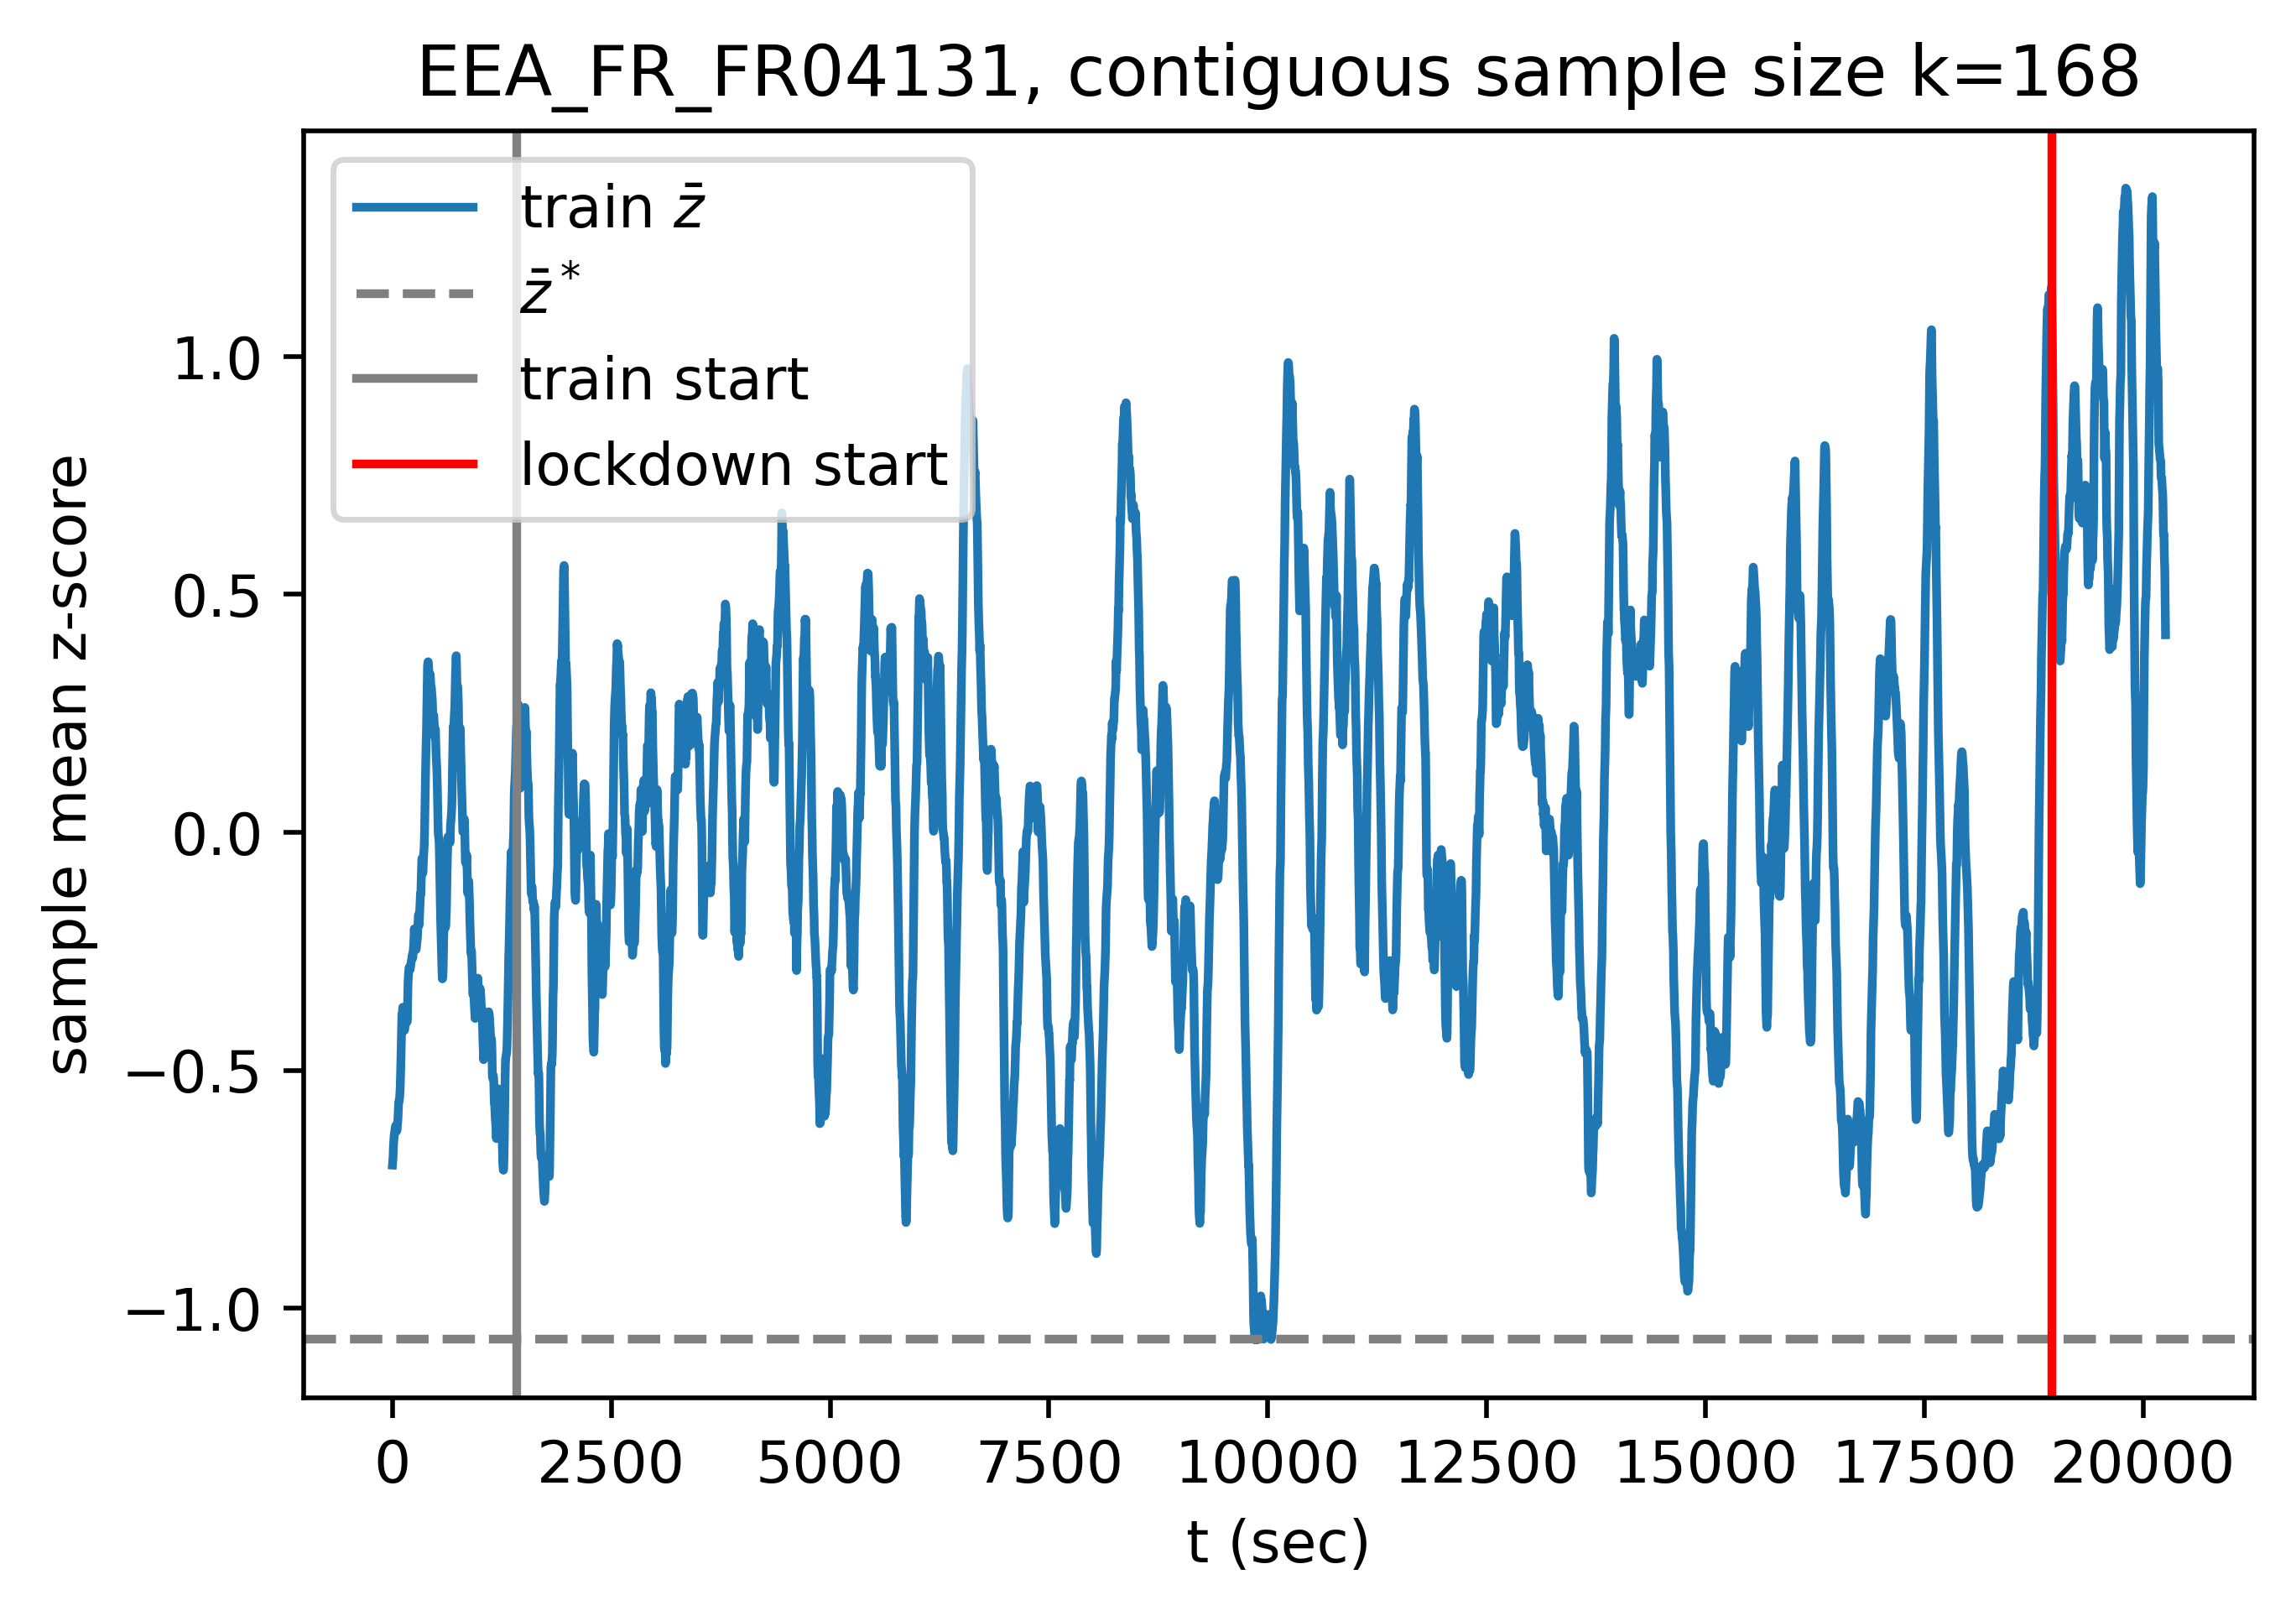

In [160]:
plt.figure(dpi=500)
plt.plot(k_averages, color="tab:blue", label="train $\\bar z$")
plt.axhline(critical_z_bar, color="gray", linestyle="--", label="$\\bar z^*$")
plt.axvline(train_start, color="gray", label="train start")
plt.axvline(train_end, color="red", label="lockdown start")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("t (sec)")
plt.ylabel("sample mean z-score")
plt.legend()

In [161]:
t2 = 5 * (t - max(t) / 2)
params2 = koop.predict(t2, covariates=t2.reshape(len(t), 1))
mu_hat2, sigma_hat2 = params2
mean_hat2 = model.mean(params2)
std_hat2 = model.std(params2)

Text(0.5, 1.0, 'EEA_FR_FR04131')

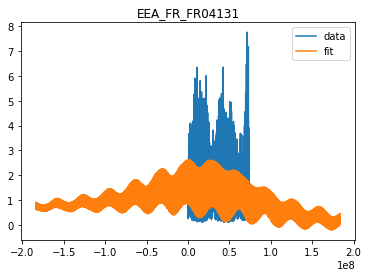

In [162]:
plt.plot(t, x, label="data")
plt.plot(t2, mean_hat2, label="fit")
plt.legend()
plt.title(station_name)

## put z-scores into a dataframe labeled by timestamp, so that we can compare between obs and model

In [163]:
len(z_scores), len(t)

(20424, 20424)

In [164]:
if station_fname.startswith("obs"):
    timestamps = obs_no2.loc[((tt in t) for tt in obs_no2.t)].ISO8601
else:
    timestamps = mod.loc[((tt in t) for tt in mod.t)].ISO8601
timestamps

360     2018-01-16 00:00:00
361     2018-01-16 01:00:00
362     2018-01-16 02:00:00
363     2018-01-16 03:00:00
364     2018-01-16 04:00:00
                ...        
20779   2020-05-15 19:00:00
20780   2020-05-15 20:00:00
20781   2020-05-15 21:00:00
20782   2020-05-15 22:00:00
20783   2020-05-15 23:00:00
Name: ISO8601, Length: 20424, dtype: datetime64[ns]

In [165]:
z_df = pd.DataFrame({"ISO8601": timestamps, "t": t, "z_score": z_scores.flatten()})
z_df.t += (t_min - 1514793600)  # align t but don't use epoch time
z_df

,ISO8601,t,z_score
360,2018-01-16 00:00:00,1296000.0,-1.045512
361,2018-01-16 01:00:00,1299600.0,-1.095772
362,2018-01-16 02:00:00,1303200.0,-1.152457
363,2018-01-16 03:00:00,1306800.0,-1.207478
364,2018-01-16 04:00:00,1310400.0,-1.246331
...,...,...,...
20779,2020-05-15 19:00:00,74800800.0,3.026735
20780,2020-05-15 20:00:00,74804400.0,2.643500
20781,2020-05-15 21:00:00,74808000.0,1.890552
20782,2020-05-15 22:00:00,74811600.0,1.542467


In [166]:
if station_fname.startswith("obs"):
    param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
    pd_name = f"obs_z_{param_str}.pkl"
    pd.to_pickle(z_df, pd_name)
pd_name

'obs_z_NormalNLL_obs_EEA_FR_FR04131_256_1024_32_1_633_0.001_0.0001.pkl'

# load z-scores for obs, so that we can compare them against model

In [167]:
pd_name = 'obs_z_NormalNLL_obs_EEA_FR_FR04131_256_1024_32_1_633_0.001_0.0001.pkl'
obs_z_df = pd.read_pickle(pd_name)

In [168]:
obs_z_df.ISO8601.min(), z_df.ISO8601.min()

(Timestamp('2018-01-16 00:00:00'), Timestamp('2018-01-16 00:00:00'))

In [169]:
from scipy import interpolate
mod_t = z_df.t.values
mod_z = z_df.z_score.values
f = interpolate.interp1d(mod_t, mod_z)
obs_t = obs_z_df.t.values
obs_z = obs_z_df.z_score.values
aligned_mod_z = f(obs_t)

In [170]:
zdiff = obs_z - aligned_mod_z

In [171]:
train_start_date = np.datetime64("2018-03-16")
train_end_date = np.datetime64("2020-03-16")
covid_end_date = np.datetime64("2020-05-16")
aligned_train_start = np.argwhere(obs_z_df.ISO8601.values >= train_start_date)[0, 0]
aligned_train_end = np.argwhere(obs_z_df.ISO8601.values <= train_end_date)[-1, 0]
aligned_covid_end = np.argwhere(obs_z_df.ISO8601.values <= covid_end_date)[-1, 0]

Text(0, 0.5, '$z_{obs} - z_{mod}$')

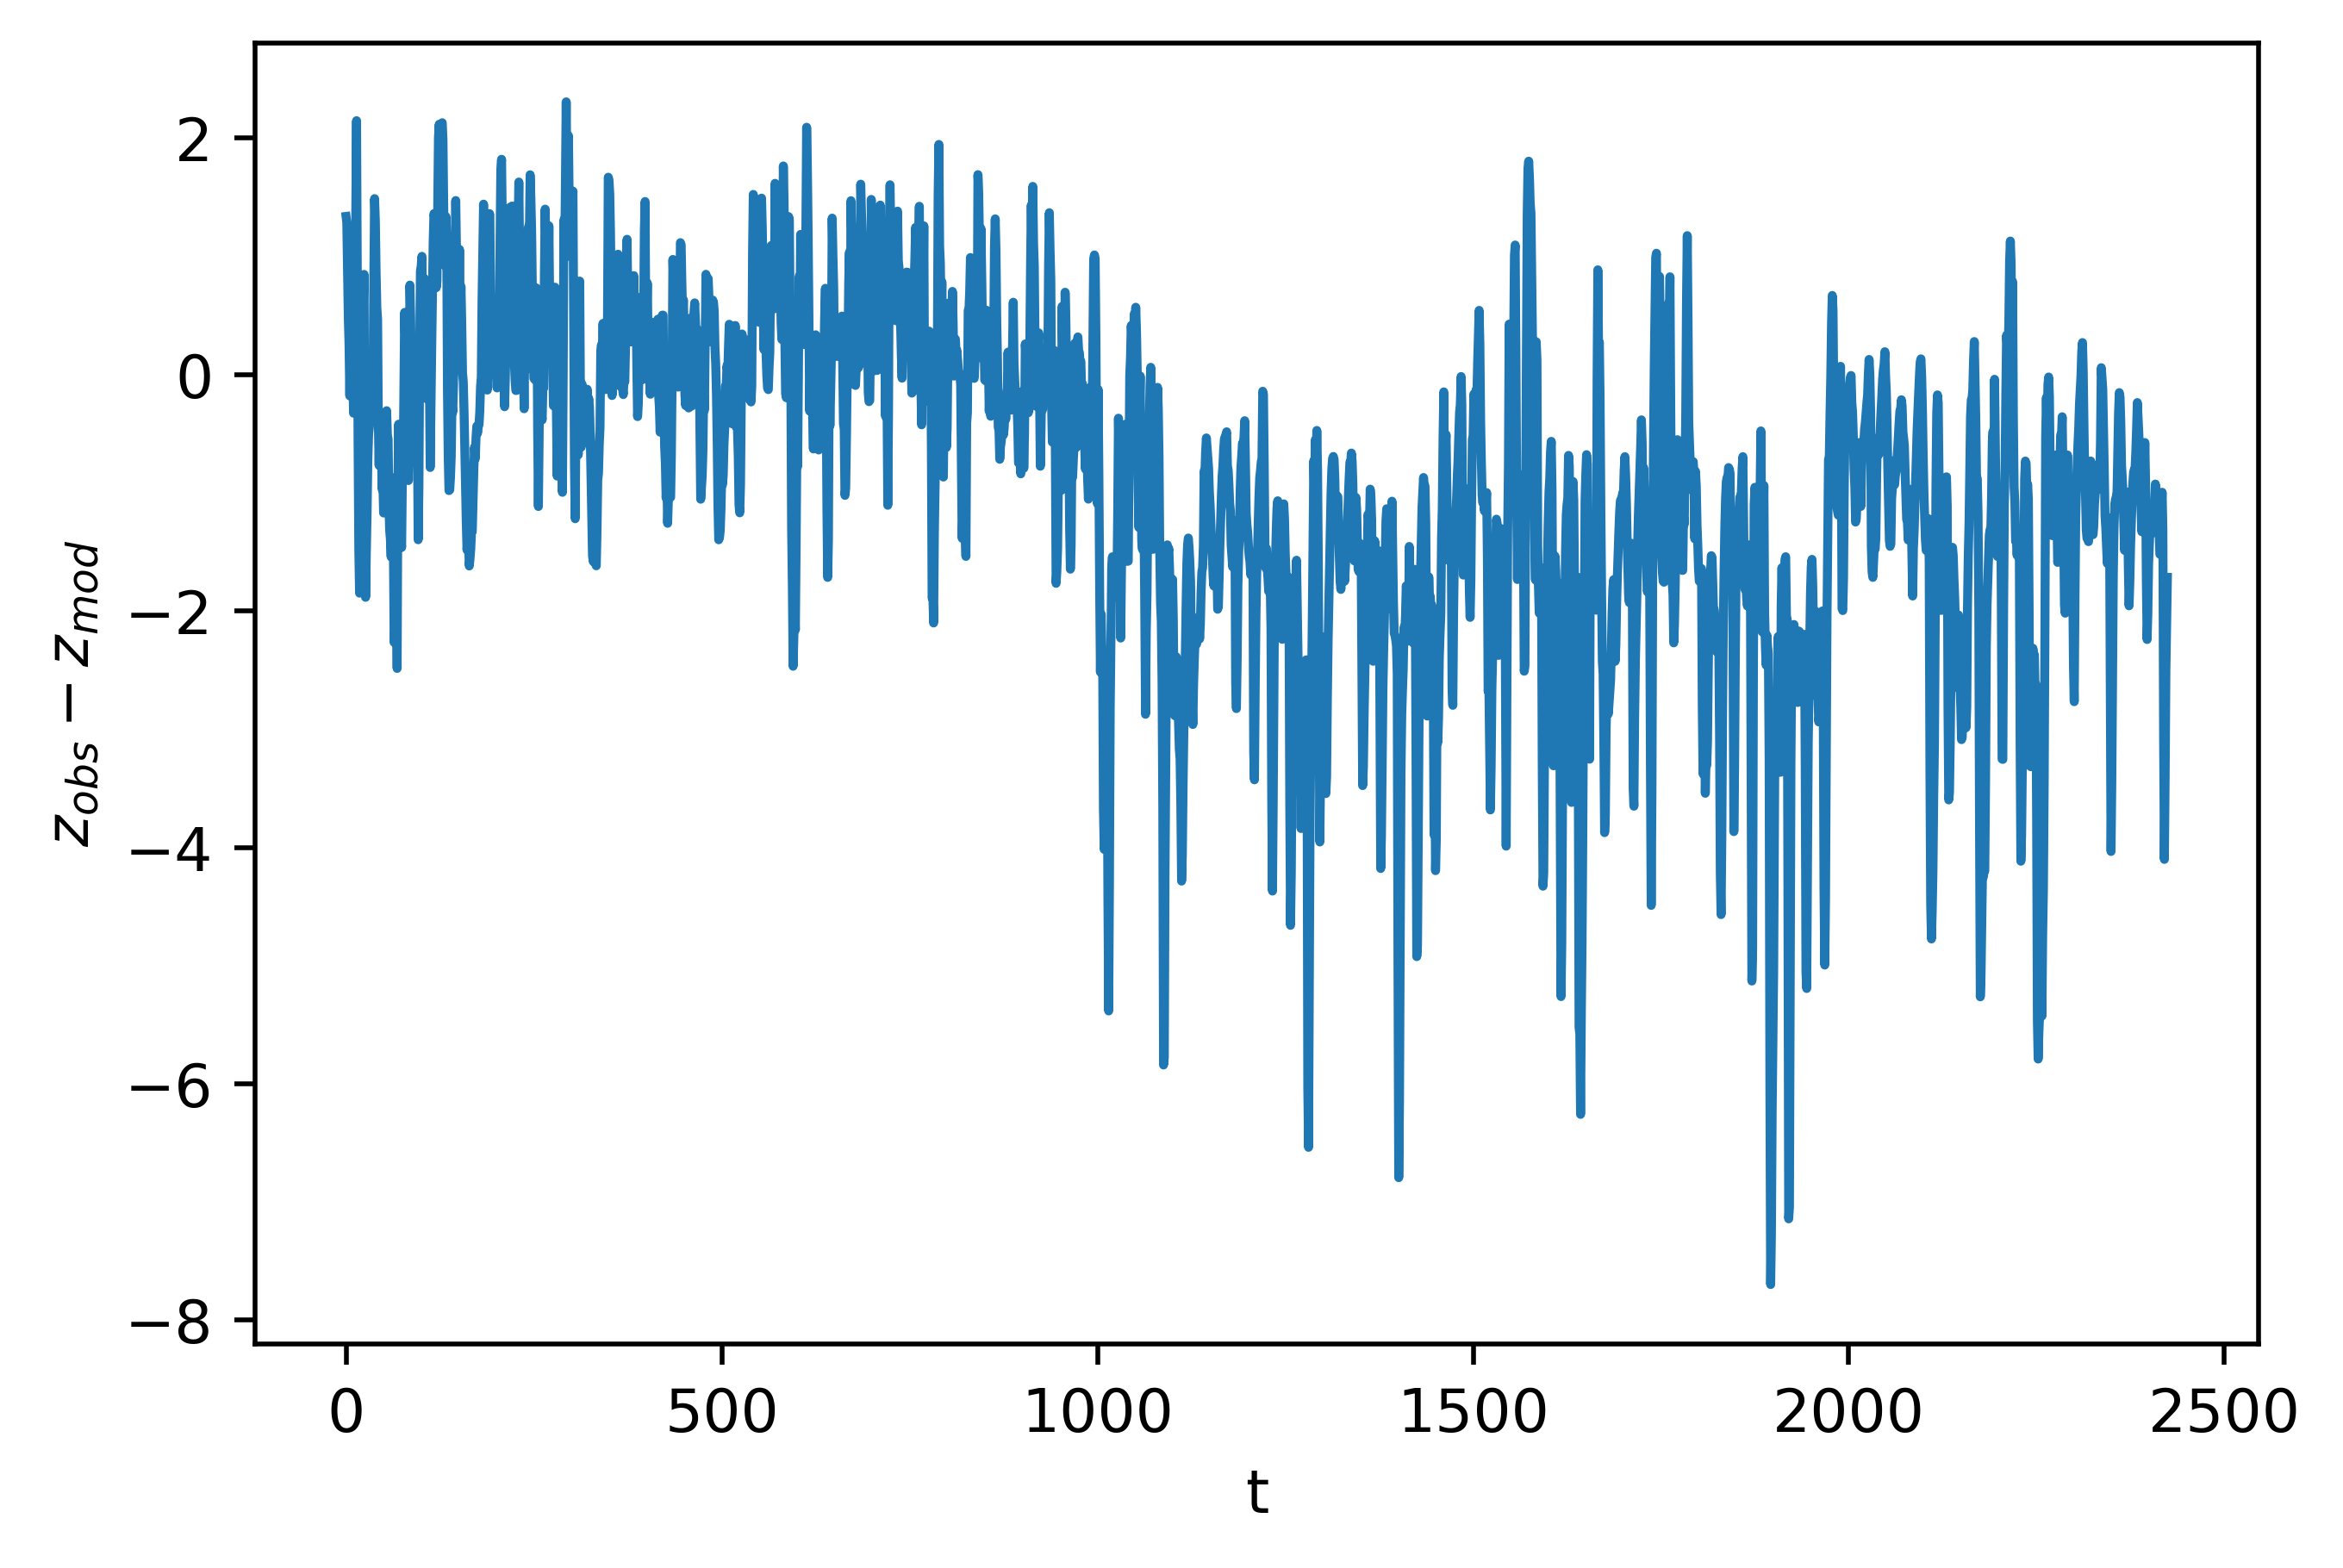

In [172]:
plt.figure(dpi=500)
plt.plot(zdiff[aligned_train_end - 1000:covid_end])
plt.xlabel("t")
plt.ylabel("$z_{obs} - z_{mod}$")

In [176]:
# find the sampling distribution of consecutive k-averages (k_average = average z-score of k consecutive observations)
k = 24 * 7
k_averages = []
k_mses = []
k_samples = np.zeros((aligned_covid_end - k + 1, k))

for i in range(0, aligned_covid_end - k + 1):
    sample = zdiff[i:i+k]
    k_averages.append(np.mean(sample))
    k_mses.append(np.mean(sample**2))
    k_samples[i, :] = sample.flatten()

train_zdiff = zdiff[aligned_train_start:aligned_train_end - k + 1]

alpha = 0.001
train_k_averages = k_averages[aligned_train_start:aligned_train_end - k + 1]
covid_k_averages = k_averages[aligned_train_end:]
control_k_averages = k_averages[:aligned_train_start - k + 1]
critical_z_bar = sorted(train_k_averages)[int(len(train_k_averages) * alpha)]

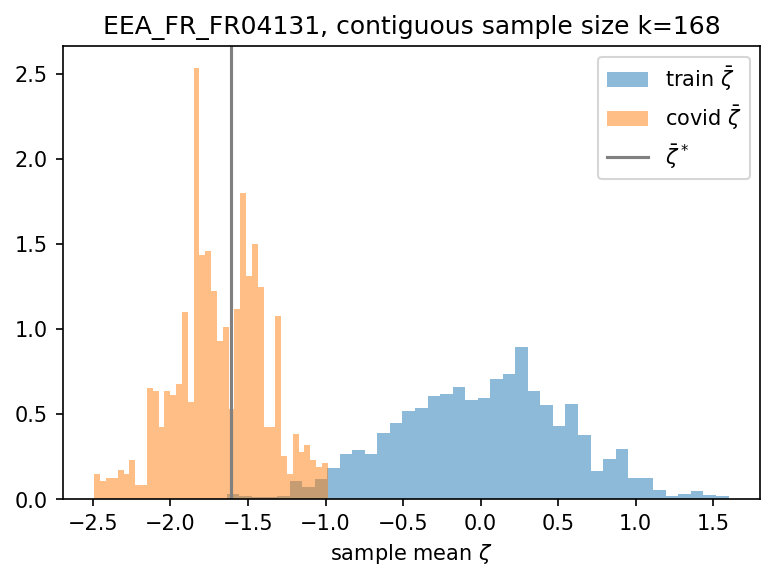

In [177]:
plt.figure(dpi=150)
plt.hist(train_k_averages, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar \zeta$")
# plt.hist(control_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="hindcast $\\bar z$")
plt.hist(covid_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar \zeta$")
plt.axvline(critical_z_bar, color="gray", label="$\\bar \zeta^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean $\zeta$")
l = np.linspace(min(train_k_averages), max(train_k_averages))
# if consecutive z-scores were iid, we would expect this distribution to have std = 1/sqrt(k)
# plt.plot(l, norm.pdf(l, loc=0, scale=1/np.sqrt(k)), label="sample mean of iid z-scores")
plt.legend()

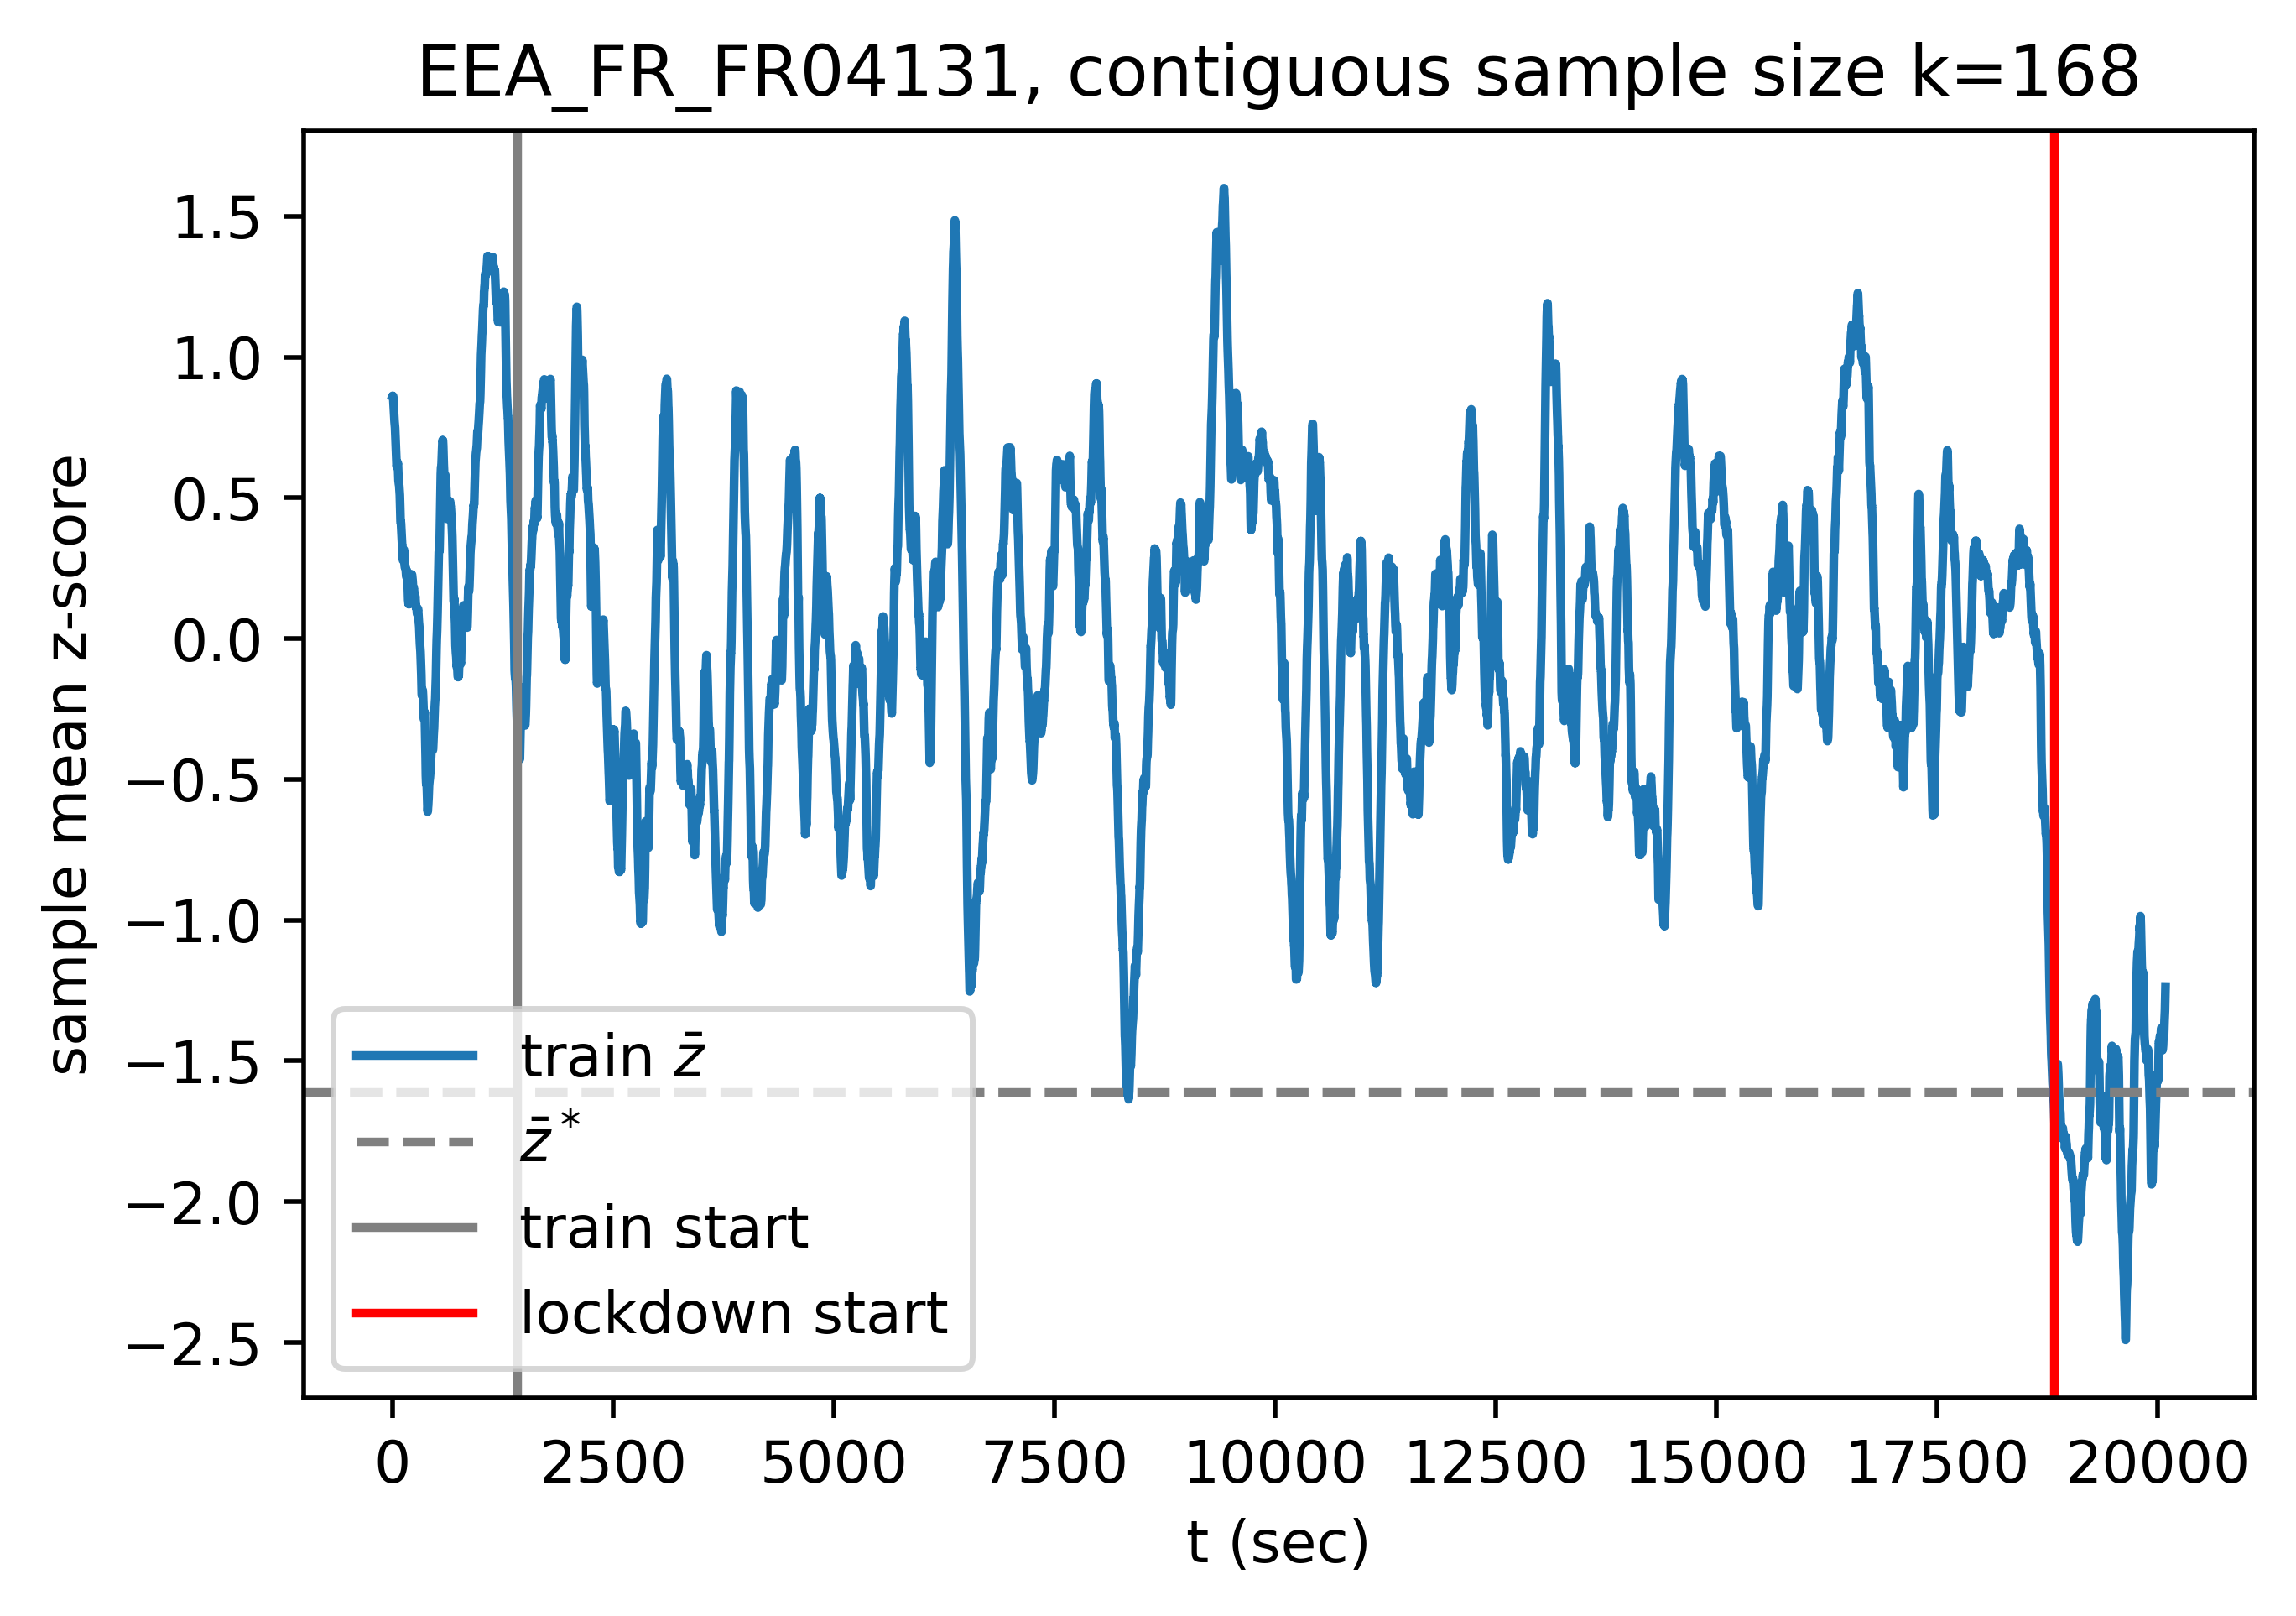

In [178]:
plt.figure(dpi=500)
plt.plot(k_averages, color="tab:blue", label="train $\\bar z$")
plt.axhline(critical_z_bar, color="gray", linestyle="--", label="$\\bar z^*$")
plt.axvline(aligned_train_start, color="gray", label="train start")
plt.axvline(aligned_train_end, color="red", label="lockdown start")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("t (sec)")
plt.ylabel("sample mean z-score")
plt.legend()

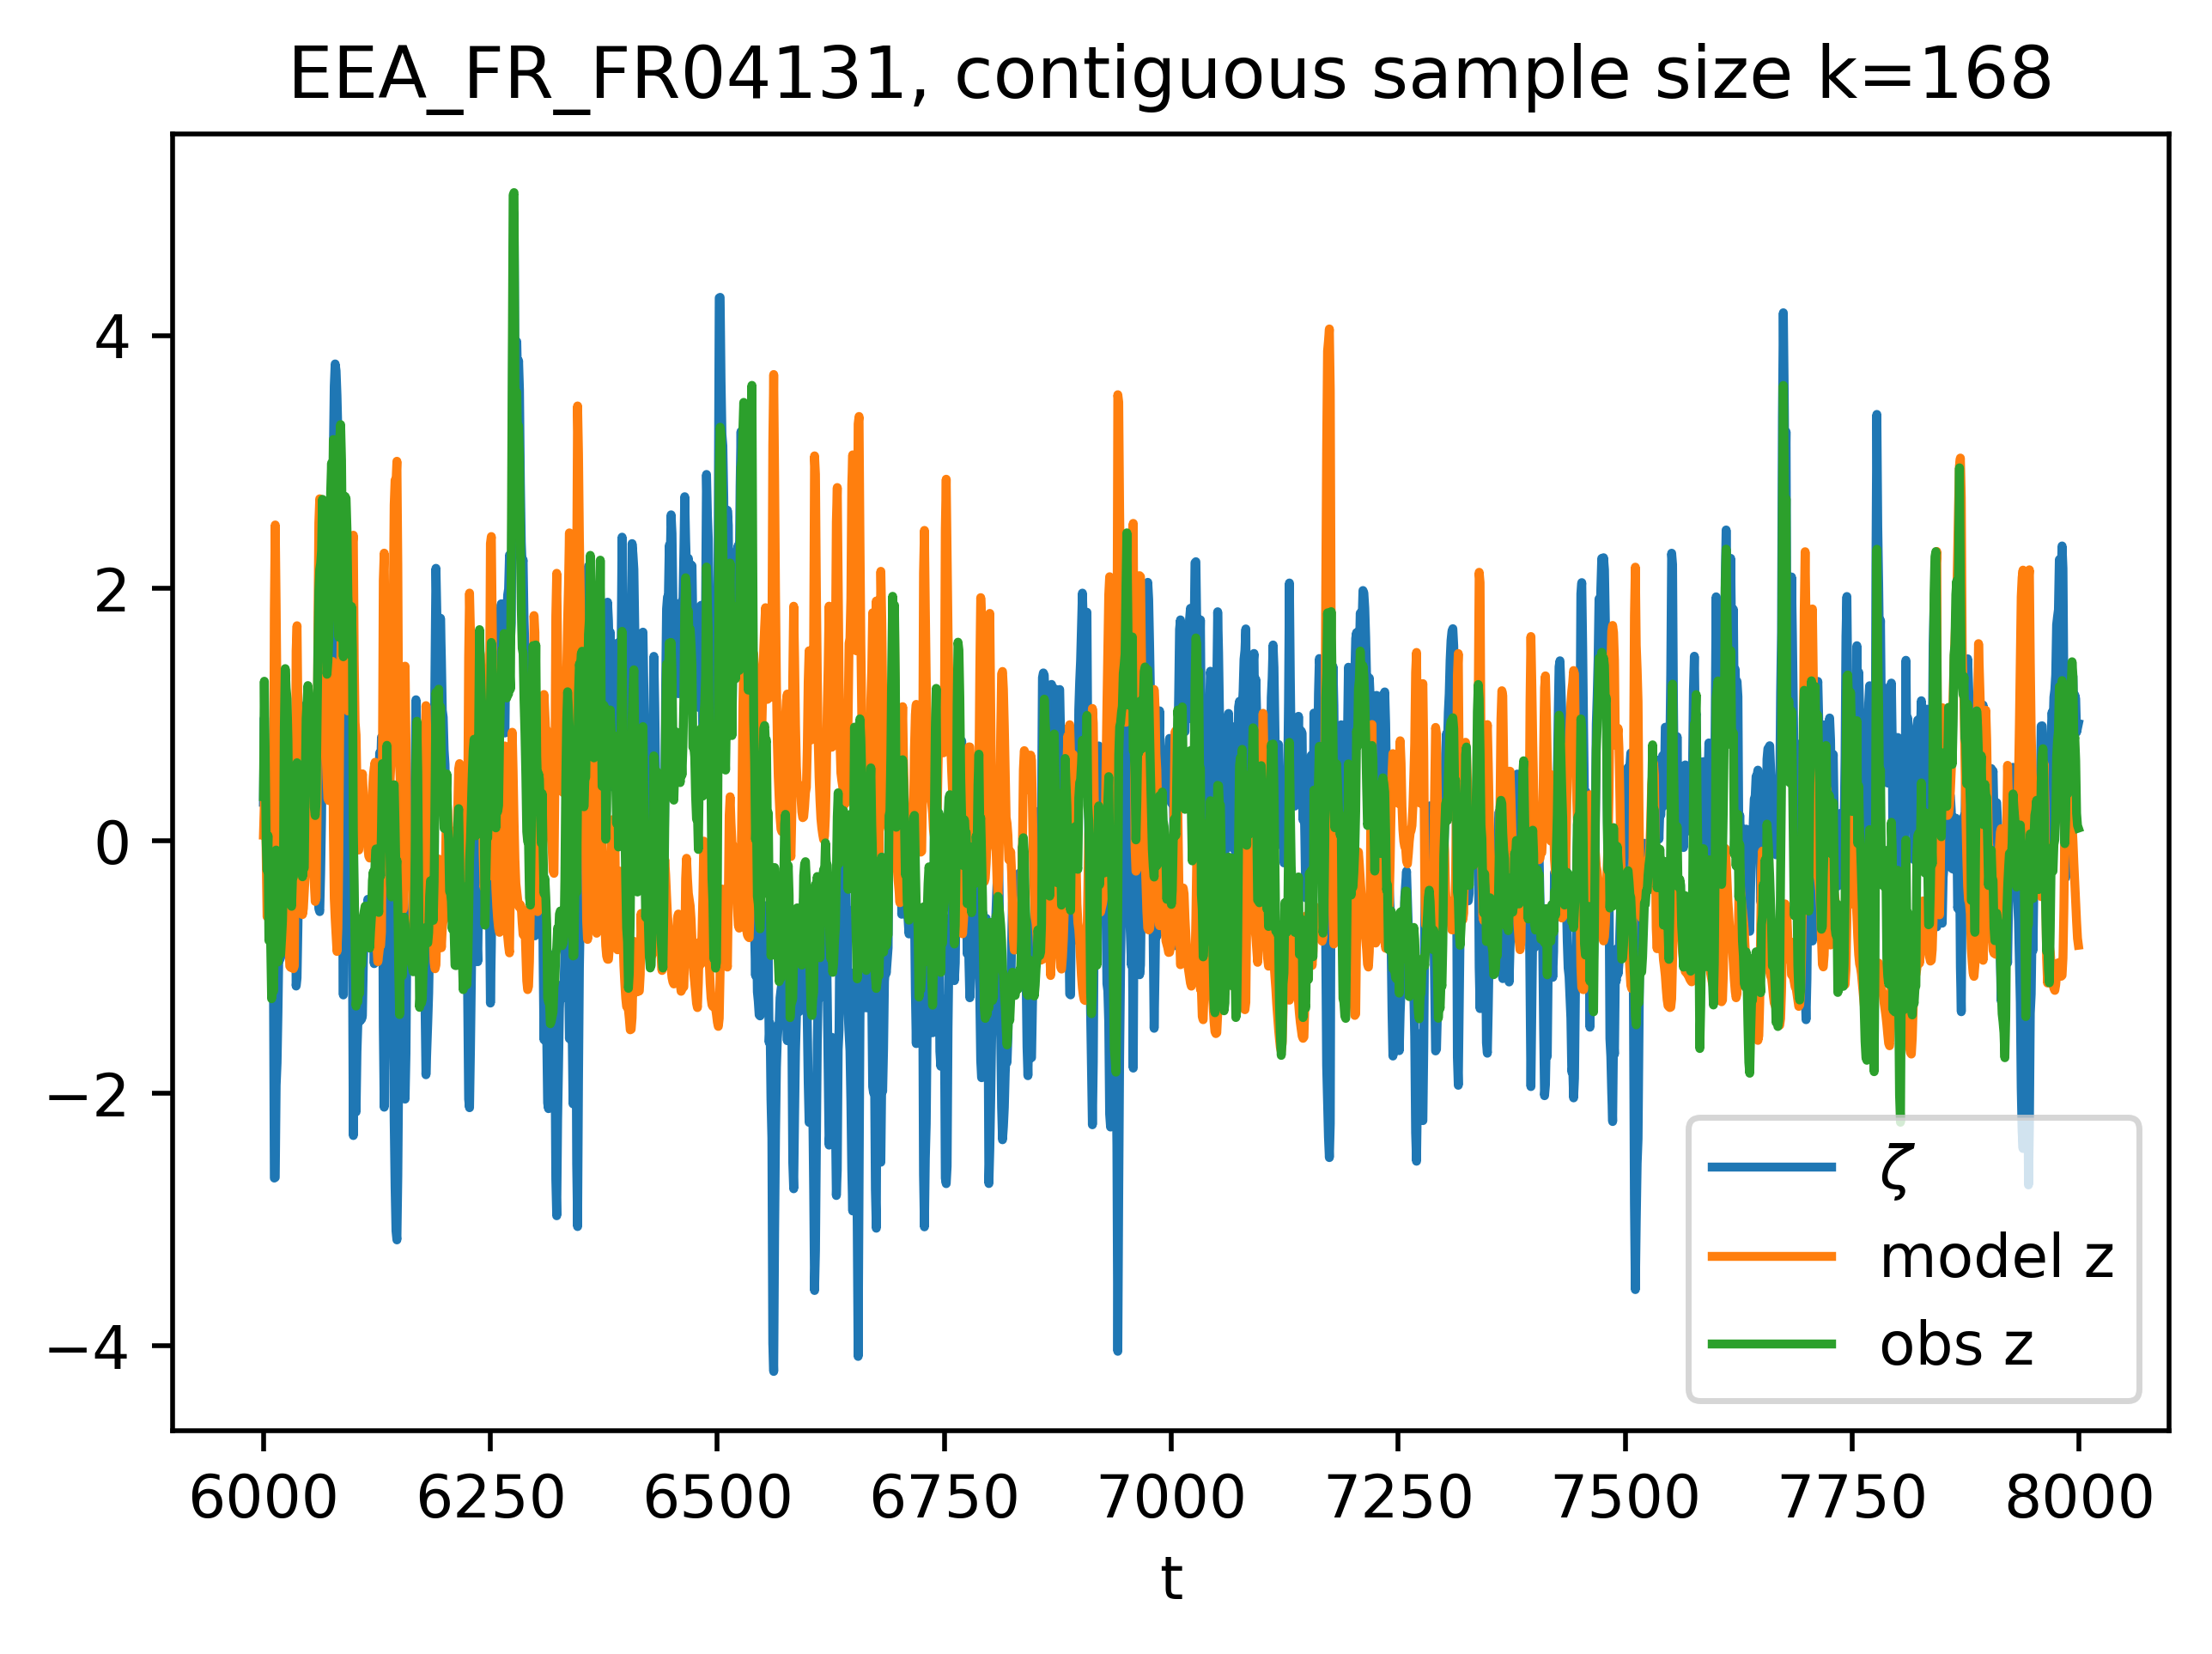

In [179]:
plt.figure(dpi=500)
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.plot(np.arange(6000, 8000), zdiff[6000:8000], label="$\zeta$")
plt.plot(np.arange(6000, 8000), aligned_mod_z[6000:8000], label="model z")
plt.plot(np.arange(6000, 8000), obs_z[6000:8000], label="obs z")
plt.xlabel("t")
# plt.ylabel("$z_{obs} - z_{mod}$")
plt.legend()